# Game state analysis

In [1]:
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [2]:
with open("../game_state_dqn.txt", "r") as f:
    lines = f.readlines()
states = [list(map(float, line.strip().split())) for line in lines[::2]]
actions = [float(line.strip()) for line in lines[1::2]]

In [3]:
def state_to_struct(state: list) -> dict:
    walls = np.array(state[:12]).reshape(6, 2)
    n_slots = state[13:16].index(1) + 4
    cur_slot = next(i for i, x in enumerate(state[16:16+6]) if x > 0)
    return {
        "walls": walls,
        "n_slots": n_slots,
        "cur_slot": cur_slot,
        "player_pos": state[22] * n_slots,
        "world_rotation": state[23],
    }

def get_cur_wall_dist(state_struct: dict) -> tuple:
    dist, width = state_struct["walls"][state_struct["cur_slot"]]
    return dist, width

def get_cur_center_offset(state_struct: dict) -> float:
    # -1: left edge, 0: center, 1: right edge
    pos = state_struct["player_pos"] * state_struct["n_slots"] 
    return (pos % 1.0) * 2.0 - 1.0

state_struct = state_to_struct(list(states[1000]))
print(get_cur_wall_dist(state_struct))
print(get_cur_center_offset(state_struct))
state_struct

(0.584683, 0.036819)
0.20000800000000396


{'walls': array([[0.36377 , 0.036819],
        [0.145066, 0.036819],
        [0.36377 , 0.036819],
        [0.145066, 0.036819],
        [0.584683, 0.036819],
        [0.145066, 0.036819]]),
 'n_slots': 6,
 'cur_slot': 4,
 'player_pos': 4.433334,
 'world_rotation': 1.0}

In [4]:
import torch
p = torch.tensor([[1,2,3], [-1,-2,0]], dtype=torch.float32)
c = torch.distributions.Categorical(logits=p)
c.sample()

tensor([1, 2])

1000it [01:53,  8.83it/s]


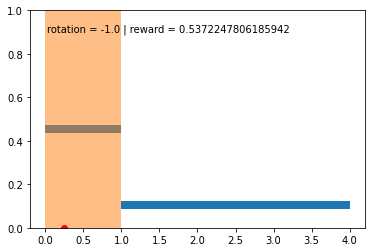

In [6]:
default_reward = 0.1
reward_slot_center_amount = 0.2

def reward(state_struct):
    r = default_reward
    center_offset = get_cur_center_offset(state_struct)
    r += reward_slot_center_amount * pow(1 - abs(center_offset), 4)
    wall_dist, wall_width = get_cur_wall_dist(state_struct)
    r += wall_dist
    return r

def plot_state(ax, state):
    state_struct = state_to_struct(state)
    ax.set_ylim(0, 1.0)
    ax.bar(list(range(state_struct["n_slots"])), height=state_struct["walls"][:state_struct["n_slots"],1], bottom=state_struct["walls"][:state_struct["n_slots"],0], width=1.0, align='edge')
    cur_slot = [0] * state_struct["n_slots"]
    cur_slot[state_struct["cur_slot"]] = 1
    ax.bar(list(range(state_struct["n_slots"])), height=cur_slot, bottom=0, width=1.0, align='edge', alpha=0.5)  # Current player slot
    ax.plot(state_struct["player_pos"], 0, 'ro')  # Player position
    ax.text(0.02, 0.9, f"rotation = {state_struct['world_rotation']} | reward = {reward(state_struct)}")

fig, ax = plt.subplots()
pathlib.Path("./figs/").mkdir(parents=True, exist_ok=True)
for i, state in tqdm(enumerate(states[1000:2000])):
    ax.cla()
    plot_state(ax, state)
    plt.savefig(f"./figs/{i:05}.png")

## Create animation of game state

In [7]:
import os
os.system("ffmpeg -y -framerate 60 -i ./figs/%05d.png -c:v libx264 dqn_states.mp4")

0

## Analyze wall distance/width distributions

In [39]:
cur_walls = []
for s in states:
    state_struct = state_to_struct(s)
    wall = state_struct["walls"][state_struct["cur_slot"]]
    cur_walls.append(wall)
cur_walls = np.stack(cur_walls)
dists = cur_walls[:, 0] * 5432
widths = cur_walls[:, 1] * 2400

<AxesSubplot:ylabel='Frequency'>

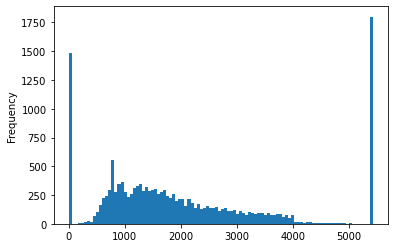

In [40]:
pd.Series(dists).plot.hist(bins=100)

166.9992

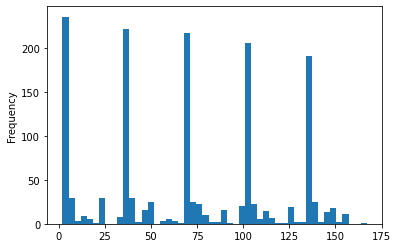

In [41]:
pd.Series(widths[dists < 0.001]).plot.hist(bins=50)
widths[dists < 0.001].max()
# Conclusion: if dist + width < 0.07: false positive wall

<AxesSubplot:ylabel='Frequency'>

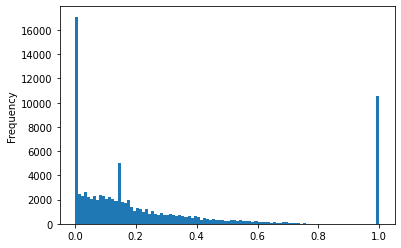

In [6]:
wall_dists = [state_to_struct(s)["walls"][:, 0] for s in states]
pd.Series(np.stack(wall_dists).flatten()).plot.hist(bins=100)

[0.9245396553821594, 0.24907641877394124, -0.5016171990847569]


e:\Mare5\dev\projects\ai-ml\.venv\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in power


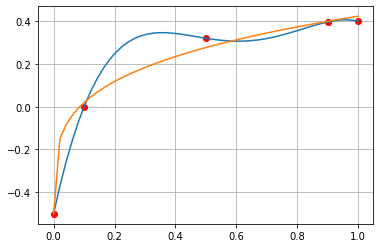

In [50]:
import scipy.optimize
import matplotlib.pyplot as plt

a = -0.5
b = 0.4
thr = 0.07

x = [0, thr, 0.5,  0.9, 1]
y = [a,   0, 0.8*b, 0.99*b, b]
t = np.linspace(0, 1)
plt.plot(x, y, 'ro')

plt.grid()
plt.plot(t, np.polyval(np.polyfit(x, y, 4), t))

def f(x, a, b, c):
    return a*pow(x,b)+c

p = scipy.optimize.curve_fit(f, x, y)[0]
print(p.tolist())
plt.plot(t, [f(x, *p) for x in t])

In [ ]:
for state in states:
    state_struct = state_to_struct(state)
    if state_struct["n_slots"] != 6:
        print(np.where(state_struct["walls"] == [1, 0])[0])

In [4]:
from collections import Counter
Counter(actions)

Counter({1: 9753, 2: 1448, 0: 4409})

# Hyperparameter optimization with Optuna

In [33]:
from datetime import datetime

import optuna
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
# PyTorch TensorBoard support
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sb3_rl import SupaEnv


DEVICE = torch.device("cuda")
EPOCHS = 50
N_TRAIN_EXAMPLES = 1e9
N_VALID_EXAMPLES = 1e9

HORIZON = 2
N_EXTRA_FEATURES = 1 + 2
INPUT_SIZE = 6*2 + 1 + 3 + 6 + 1 + 1 + N_EXTRA_FEATURES
OUT_SIZE = 3


def preprocess_state(state):
    state_struct = SupaEnv.state_to_struct(state)
    state_struct = SupaEnv.add_state_features(state_struct)
    state = state_struct["_packed"]
    return state

def stack_states(states, actions, i, *, horizon):
    obs_history = np.zeros(INPUT_SIZE * (horizon + 1), dtype=np.float32)
    action_history = np.zeros(horizon)
    for j in range(max(0, i - horizon), i + 1):
        obs = states[j]
        action = 0 # actions[i]
        last_ax_size = obs.shape[-1]

        obs_history = np.roll(obs_history, shift=-last_ax_size, axis=-1)
        obs_history[..., -obs.shape[-1] :] = obs

        action_history = np.roll(action_history, shift=-1, axis=-1)
        action_history[..., -1:] = action
    return np.concatenate((obs_history, action_history), dtype=np.float32)

def read_data(path):
    with open(path, "r") as f:
        lines = f.readlines()
    states = [list(map(float, line.strip().split())) for line in lines[::2]]
    actions = [float(line.strip()) for line in lines[1::2]]
    
    states = np.array(list(map(preprocess_state, states)), dtype=np.float32)
    actions = np.array(actions, dtype=np.int64) + 1  # (-1,0,1) -> (0,1,2)
    stacked_states = []
    for i in range(len(states)):
        stacked_states.append(stack_states(states, actions, i, horizon=HORIZON))
    return stacked_states, actions

def get_data(batch_size, test_size=0.33):
    states, actions = read_data("../game_state_dqn.txt")
    X_train, X_test, y_train, y_test = train_test_split(states, actions, test_size=test_size, shuffle=False, random_state=42)
    # print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    training_loader = torch.utils.data.DataLoader(
        list(zip(X_train, y_train)), 
        batch_size=batch_size)
    validation_loader = torch.utils.data.DataLoader(
        list(zip(X_test, y_test)), 
        batch_size=batch_size)
    return training_loader, validation_loader

def define_model(trial: optuna.Trial, *, input_size):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 1, 3)
    layers = []
    in_features = input_size
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 4, 256)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        p = trial.suggest_float("dropout_l{}".format(i), 0.0, 0.5)
        layers.append(nn.Dropout(p))
        in_features = out_features
    layers.append(nn.Linear(in_features, OUT_SIZE))
    layers.append(nn.LogSoftmax(dim=1))
    return nn.Sequential(*layers)

def objective(trial: optuna.Trial):
    # batch_size = trial.suggest_int("batch_size", 1, 1024)
    batch_size = 128
    train_loader, valid_loader = get_data(batch_size)

    # Generate the model.
    input_size = train_loader.dataset[0][0].shape[-1]
    model = define_model(trial, input_size=input_size).to(DEVICE)

    # Generate the optimizers.
    # optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    optimizer_name = "Adam" 
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)

    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * batch_size >= N_TRAIN_EXAMPLES:
                break

            data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)

            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(valid_loader):
                # Limiting validation data.
                if batch_idx * batch_size >= N_VALID_EXAMPLES:
                    break
                data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
                output = model(data)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = correct / min(len(valid_loader.dataset), N_VALID_EXAMPLES)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [29]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)

pruned_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-10-11 11:49:48,496] A new study created in memory with name: no-name-a097e852-62f5-4a70-bc14-9ef01c44f19c
[I 2022-10-11 11:50:08,198] Trial 0 finished with value: 0.9082911223673688 and parameters: {'n_layers': 3, 'n_units_l0': 74, 'dropout_l0': 0.27216958189941215, 'n_units_l1': 105, 'dropout_l1': 0.2541258284187212, 'n_units_l2': 147, 'dropout_l2': 0.12311062130762035, 'lr': 0.0053146924801565285}. Best is trial 0 with value: 0.9082911223673688.
[I 2022-10-11 11:50:22,906] Trial 1 finished with value: 0.8541722207411357 and parameters: {'n_layers': 1, 'n_units_l0': 225, 'dropout_l0': 0.46413325840364844, 'lr': 0.00020821865732252722}. Best is trial 0 with value: 0.9082911223673688.
[I 2022-10-11 11:50:42,645] Trial 2 finished with value: 0.880831778192482 and parameters: {'n_layers': 3, 'n_units_l0': 33, 'dropout_l0': 0.2040439556442431, 'n_units_l1': 11, 'dropout_l1': 0.4607755070789919, 'n_units_l2': 231, 'dropout_l2': 0.3008822412617268, 'lr': 0.006835321398645488}. Best i

Study statistics: 
  Number of finished trials:  200
  Number of pruned trials:  168
  Number of complete trials:  32
Best trial:
  Value:  0.9402825913089843
  Params: 
    n_layers: 3
    n_units_l0: 229
    dropout_l0: 0.2205320834231246
    n_units_l1: 146
    dropout_l1: 0.4396691538383308
    n_units_l2: 152
    dropout_l2: 0.05657711479553102
    lr: 0.0018561838204790855


In [30]:
import optuna.visualization as opt_vis

fig1 = opt_vis.plot_optimization_history(study)
fig2 = opt_vis.plot_param_importances(study)
fig3 = opt_vis.plot_intermediate_values(study)
fig4 = opt_vis.plot_parallel_coordinate(study)

fig1.show()
fig2.show()
fig3.show()
fig4.show()

# Pretraining the policy network

In [58]:
from typing import Any, Dict, List, Optional, Type
import gym

from stable_baselines3.dqn.policies import QNetwork, DQNPolicy


def create_dropout_mlp(
    input_dim: int,
    output_dim: int,
    net_arch: List[int],
    dropout_arch: List[float],
    activation_fn: Type[nn.Module] = nn.ReLU,
    squash_output: bool = False,
) -> List[nn.Module]:
    if len(net_arch) > 0:
        modules = [nn.Linear(input_dim, net_arch[0]), activation_fn(), nn.Dropout(dropout_arch[0])]
    else:
        modules = []

    for idx in range(len(net_arch) - 1):
        modules.append(nn.Linear(net_arch[idx], net_arch[idx + 1]))
        modules.append(activation_fn())
        modules.append(nn.Dropout(dropout_arch[idx + 1]))

    if output_dim > 0:
        last_layer_dim = net_arch[-1] if len(net_arch) > 0 else input_dim
        modules.append(nn.Linear(last_layer_dim, output_dim))
    if squash_output:
        modules.append(nn.Tanh())
    return modules

def pretrain():
    batch_size = 128
    train_loader, valid_loader = get_data(batch_size, test_size=1)

    # Generate the model.
    input_size = train_loader.dataset[0][0].shape[-1]
    layers = create_dropout_mlp(input_size, OUT_SIZE, [115, 97], [0.097, 0.11], nn.ReLU)
    layers.append(nn.LogSoftmax(dim=1))
    model = nn.Sequential(*layers).to(DEVICE)

    # Generate the optimizers.
    optimizer_name = "Adam" 
    lr = 0.002918176734371477
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)

    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * batch_size >= N_TRAIN_EXAMPLES:
                break

            data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)

            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

    # Remove last LogSoftmax layer
    model = nn.Sequential(*list(model.children())[:-1])
    return model


class CustomQNetwork(QNetwork):
    def __init__(
        self,
        observation_space: gym.spaces.Space,
        action_space: gym.spaces.Space,
        features_extractor: nn.Module,
        features_dim: int,
        net_arch: Optional[List[int]] = None,
        activation_fn: Type[nn.Module] = nn.ReLU,
        normalize_images: bool = True,
    ):
        super().__init__(observation_space, action_space, features_extractor, features_dim, 
            net_arch=net_arch, activation_fn=activation_fn, normalize_images=normalize_images)

        dropout_arch = [0.097, 0.11]
        q_net = create_dropout_mlp(self.features_dim, self.action_space.n, [115, 97], dropout_arch, nn.ReLU)
        # q_net = create_dropout_mlp(self.features_dim, self.action_space.n, self.net_arch, dropout_arch, self.activation_fn)
        self.q_net = nn.Sequential(*q_net)

class CustomDQNPolicy(DQNPolicy):
    def make_q_net(self):
        # Make sure we always have separate networks for features extractors etc
        net_args = self._update_features_extractor(self.net_args, features_extractor=None)
        return CustomQNetwork(**net_args).to(self.device)

In [59]:
model = pretrain()
model

Sequential(
  (0): Linear(in_features=83, out_features=115, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.097, inplace=False)
  (3): Linear(in_features=115, out_features=97, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.11, inplace=False)
  (6): Linear(in_features=97, out_features=3, bias=True)
)

In [60]:
torch.save(model.state_dict(), "pretrained.pth")

## Comparison with RandomForests

In [61]:
from sklearn.ensemble import RandomForestClassifier

train, valid = get_data(1)
X_train, y_train = map(np.array, zip(*train.dataset))
X_test, y_test = map(np.array, zip(*valid.dataset))

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [62]:
# loss_fn(torch.tensor(rf.predict_proba(X_test)), torch.tensor(y_test))
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1204
           1       0.93      0.90      0.92      2336
           2       0.72      0.69      0.70       211

    accuracy                           0.88      3751
   macro avg       0.82      0.82      0.82      3751
weighted avg       0.88      0.88      0.88      3751



# Plots

In [2]:
import joblib

dagger_data = joblib.load("dagger_data.gz")
dagger_scores = dagger_data['score_history'][1:]

In [4]:
import json

with open("checkpoints/sb3_15/data", "r") as f:
    dqn_data = json.load(f)
dqn_scores = dqn_data["_env_real_episode_scores"]

In [5]:
def moving_average(x, k=10):
    y = []
    s = 0
    for i in range(min(k, len(x))):
        s += x[i]
        y.append(s / (i + 1))
    for i in range(k, len(x)):
        s = s - x[i - k] + x[i]
        y.append(s / k)
    return y

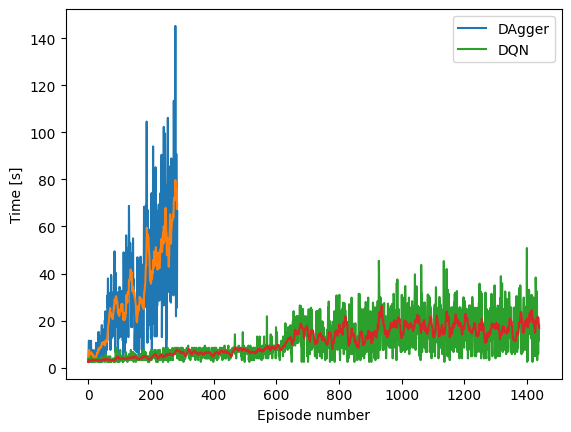

In [6]:
fig, ax = plt.subplots()

ax.set_ylabel('Time [s]')
ax.set_xlabel('Episode number')

x = np.array(dagger_scores) / 60  # Seconds
ax.plot(x, label="DAgger")
ax.plot(moving_average(x, k=10))

x = np.array(dqn_scores) / 60  # Seconds
ax.plot(x, label="DQN")
ax.plot(moving_average(x, k=10))

ax.legend()
fig.savefig("../figs/scores.png", dpi=80)